# Productions @ Event-level

Ultimately, our objective is to conduct a comparative analysis of the data and simulations.
<br>
Therefore, it is important to have both information with the same structure at event-level.

In [1]:
import sys
sys.path.append('/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/libs')

import crudo
import fit_functions as ff
import glob
from   iminuit import Minuit
from   iminuit.cost import LeastSquares
from   invisible_cities.reco.corrections import read_maps
from   invisible_cities.reco.corrections import apply_all_correction
from   invisible_cities.types.symbols    import NormStrategy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotting_tools as pt
import tables as tb
from   scipy import integrate
from   scipy.optimize import curve_fit
from   scipy.stats    import linregress

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Preliminary

In [2]:
# ----- Important Directories ----- #
data_dir   = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/sophronia/'                           # Runs per ldc
icaros_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/icaros/'                              # Kr maps per run
MC_dir     = '/lustre/ific.uv.es/prj/gl/neutrinos/NEXT/MC/NEXT100/Radiogenics/LPR/IC_v2.3.1/NEXUS_v7_08_01/'    # MC directory
output_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Backgrounds/h5/'                      # Output directory for the h5 files

# Paths of the tables inside the HDF5 file. These are the keys used to access the datasets
dorothea_key  = '/DST/Events'
sophronia_key = '/RECO/Events'

# Data Production

In [4]:
# List of the low-background runs
runs_info = {
                # Condition: castle = closed & RAS = on #
                # Jun 2025
                # 15502: {"duration": 85477, "OK": 28287, "LOST": 9564  , "proc_eff": 1.0   },
                # 15504: {"duration": 85194, "OK": 28297, "LOST": 9537  , "proc_eff": 0.9999},
                # 15505: {"duration": 86517, "OK": 28632, "LOST": 9725  , "proc_eff": 0.9999},
                # 15506: {"duration": 84841, "OK": 28438, "LOST": 9603  , "proc_eff": 0.9999},
                # 15507: {"duration": 55740, "OK": 18569, "LOST": 6149  , "proc_eff": 0.9999},
                # 15514: {"duration": 59207, "OK": 20054, "LOST": 6646  , "proc_eff": 0.9999},
                # 15519: {"duration": 34045, "OK": 11420, "LOST": 3646  , "proc_eff": 0.9998},
                # 15520: {"duration": 85170, "OK": 28050, "LOST": 9130  , "proc_eff": 1.0   },
                # 15521: {"duration": 85388, "OK": 28396, "LOST": 8831  , "proc_eff": 1.0   },
                # 15527: {"duration": 69725, "OK": 23560, "LOST": 7411  , "proc_eff": 1.0   },
                # 15528: {"duration": 41361, "OK": 13460, "LOST": 4426  , "proc_eff": 1.0   },
                # 15535: {"duration": 84904, "OK": 28799, "LOST": 9156  , "proc_eff": 0.9998},
                # 15539: {"duration": 56567, "OK": 15618, "LOST": 9586  , "proc_eff": 0.9997},
                # 15540: {"duration": 67663, "OK": 22526, "LOST": 7066  , "proc_eff": 0.9993},
                # 15541: {"duration": 86630, "OK": 29124, "LOST": 9333  , "proc_eff": 1.0   },
                # 15542: {"duration": 87915, "OK": 29717, "LOST": 9274  , "proc_eff": 1.0   },
                # 15543: {"duration": 86570, "OK": 29160, "LOST": 9123  , "proc_eff": 1.0   },
                # 15544: {"duration": 86566, "OK": 29498, "LOST": 9029  , "proc_eff": 1.0   },
                # 15545: {"duration": 85892, "OK": 29437, "LOST": 8877  , "proc_eff": 1.0   },
                # 15546: {"duration": 84822, "OK": 28663, "LOST": 8704  , "proc_eff": 1.0   },
                # 15547: {"duration": 71594, "OK": 24549, "LOST": 7421  , "proc_eff": 1.0   },
                # 15557: {"duration": 66088, "OK": 22273, "LOST": 6929  , "proc_eff": 1.0   },
                # Jul 2025
                15609: {"duration": 79563, "OK": 26885, "LOST": 8392} 
            }

In [27]:
trigger = 0
for run_id, entry in runs_info.items():

    ok_trigg = entry['OK']
    trigger += ok_trigg

print(f"Total number of triggers: {trigger}")

Total number of triggers: 546527


## Processing

In [3]:
# Drift velocity
V_drift = 0.865     # in [mm/μs]

# Cut parameters to avoid Po-like events
m = 0.17;  b = -56

# ----- Information for S1e Correction ----- #
# Cathode temporal position
DT_stop = 1372.2543             # in [μs]
# Fit values
CV_fit = [0.57, 796.53]     # Run 14739 Fit: χ² / ndof = 1.8480

# S1 energy threshold
S1e_tresh = 900

# Setting up the filter of spurious hits
filter_config = {'distance': [15., 15.], 'nhit': 3, 'variables': ['E_corr']}
NO_hits_sp = crudo.drop_isolated_clusters(**filter_config)

### Testing Zone

In [ ]:
test_path = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/sophronia/run_15557_ldc7_trg2_sophronia.h5'
test_dor = pd.read_hdf(test_path, key=dorothea_key)

In [22]:
test_dor
# test_dor[(test_dor.nS1 == 1)]

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,273,1.750856e+09,0,0,1,2,350.0,238.949768,1326.063110,47875.0,...,3308,1370.614258,1370.614258,7.818416,42.104793,190.017714,194.626681,1.352736,167.227976,220.582271
1,273,1.750856e+09,0,1,1,2,350.0,238.949768,1326.063110,47875.0,...,173,2435.623535,2435.623535,5.316910,212.340133,-15.541531,212.908129,-0.073061,277.389754,196.176064
2,595,1.750856e+09,0,0,1,1,700.0,150.759277,896.120239,1061875.0,...,2625,346.611389,346.611389,5.770755,-250.887920,34.987742,253.315792,3.003031,273.921482,167.552151
3,903,1.750856e+09,0,0,1,1,625.0,175.702057,1034.496094,458750.0,...,1759,948.739441,948.739441,7.578737,52.836695,-207.537386,214.157612,-1.321503,193.166629,287.372902
4,1869,1.750856e+09,0,0,92,1,425.0,11.253611,186.188797,2475.0,...,3579,1399.014038,1399.014038,401.972250,27.327882,41.639342,49.806104,0.990005,245.660872,247.832615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25166,1986950,1.750921e+09,0,0,1,1,350.0,224.470032,1374.674805,48000.0,...,3310,1370.486816,1370.486816,7.868868,-117.739716,-182.176325,216.912089,-2.144563,186.559334,216.534747
25167,1987251,1.750921e+09,0,0,1,1,475.0,272.809692,1538.187500,51800.0,...,3286,1367.688354,1367.688354,7.838963,-156.307327,-28.698121,158.919989,-2.960014,206.986641,163.903431
25168,1989351,1.750922e+09,0,0,1,2,950.0,61.958851,1601.064819,240200.0,...,1927,-196.592285,-196.592285,39.246973,7.371021,12.489523,14.502418,1.037631,262.574235,261.258664
25169,1989351,1.750922e+09,0,1,1,2,950.0,61.958851,1601.064819,240200.0,...,3153,1175.287109,1175.287109,7.925132,96.785708,158.718872,185.900924,1.023207,181.092025,204.806005


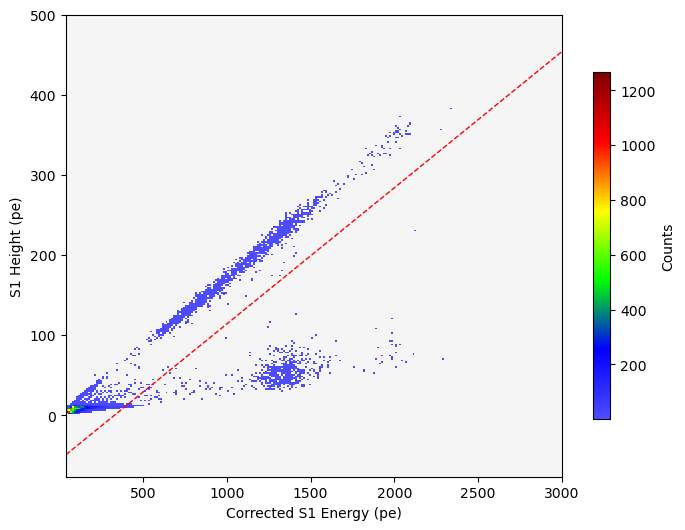

In [31]:
# Global
n_bins = 250
H1_max = 500; E1_max  = 3e3

# Limit line parameters: from selecting_criteria.ipynb
m = 0.17
b = -56

# Masked dataframe
mask_df = test_dor.copy()
# mask_df = mask_df[(mask_df['nS2'] == 1)]      # Only one S1

# Variables
H1 = mask_df['S1h']
E1 = mask_df['S1e']

# Binning
H1_bins = np.linspace(H1.min(), H1_max, n_bins)
E1_bins = np.linspace(E1.min(), E1_max, n_bins)

# 2D histogram: normalized by corrected DAQ data taking time
S1h_S1e_map, ex, ey = np.histogram2d(E1, H1, bins=[E1_bins, H1_bins])
S1h_S1e_map         = np.ma.masked_where(S1h_S1e_map==0, S1h_S1e_map)     # Zero values masked

# ----- Plotting ----- #
plt.figure(figsize=(8, 6))
plt.pcolormesh(ex, ey, S1h_S1e_map.T, cmap=pt.custom_hsv, shading='auto')
plt.plot(E1_bins, ff.linear_func(E1_bins, m, b), c='red', ls='--', lw=1)        # Limit line

# ----- Styling ----- #
cbar = plt.colorbar(label='Counts', shrink=0.75)
# cbar.formatter.set_powerlimits((-3, -3))
plt.xlabel('Corrected S1 Energy (pe)')
plt.ylabel('S1 Height (pe)')
# plt.title(r'Data with $nS1 = 1$')

plt.gca().set_facecolor("whitesmoke")
plt.show()

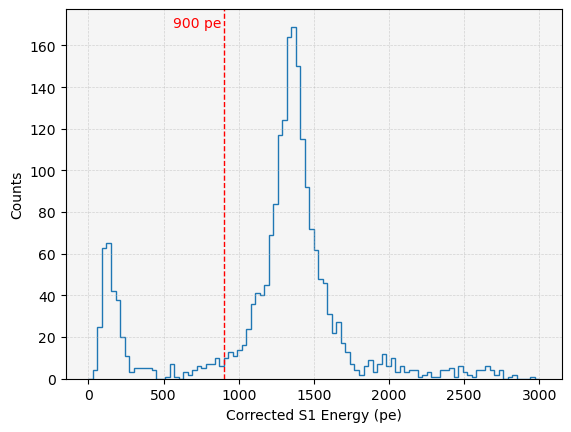

In [40]:
# Global
n_bins = 100
x_min, x_max = 0, 3e3
x_edges = np.linspace(x_min, x_max, n_bins + 1)

# Polike parameters avoiding
m = 0.17;  b = -56

# ----- Information for S1e Correction ----- #
# Cathode temporal position
DT_stop = 1372.2543             # in [μs]
# Fit values
CV_fit = [0.62, 869.87]         # [slope, intercept]

# S1 energy threshold
S1e_tresh = 900

# Data
datiuks = test_dor.copy()
datiuks = datiuks[(datiuks['nS1'] == 1)]      # Only one S1
datiuks = datiuks[datiuks['S1h'] >= m * datiuks['S1e'] + b]

# ----- S1e Correction ----- #
datiuks = crudo.correct_S1e(datiuks, CV_fit, DT_stop, output_column='S1e_corr')     # I'll work with this corrected S1 energy

# Variables
E1 = datiuks['S1e_corr']

# Histogram: normalized by corrected DAQ data taking time
E1_counts, E1_edges = np.histogram(E1, bins=x_edges)

# ----- Plotting ----- #
plt.stairs(E1_counts, E1_edges,fill=False, lw=1.0)
    
# S1 energy threshold
plt.axvline(x=S1e_tresh, color='red', ls='--', lw=1)
plt.text(0.98*S1e_tresh, E1_counts.max(), f'{S1e_tresh} pe', c='red', ha='right')

# ----- Styling ----- #
plt.xlabel('Corrected S1 Energy (pe)')
plt.ylabel('Counts')
# plt.yscale('log')
# plt.ticklabel_format(axis='y', style='sci', scilimits=(-2, -2))
# plt.legend(loc='best', fontsize=9)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

### Execution Zone

In [5]:
# Store all the processed dfs
all_processed_dfs = []

# Total efficiency counters
Total_reco  = 0   
Total_Zgood = 0
Total_nS1_one  = 0;      Total_NO_polike   = 0
Total_electron = 0;      Total_NO_spurious = 0
Total_final = 0

# ----- Run Loop ----- #
for run_id, entry in runs_info.items():

    print(f"--- Processing run {run_id} ---")

    # ----- Krypton Map ----- #
    try:
        kr_file = f'run_{run_id}.v2.3.1.20250512.Kr.map.h5'
        kr_path = os.path.join(icaros_dir, kr_file)
        # Read map and create correction function
        cmap = read_maps(kr_path)
        corr_func = apply_all_correction(cmap, apply_temp=False, norm_strat=NormStrategy.kr)
    except FileNotFoundError:
        print(f"Kr map for run {run_id} not found. Skipping...")
        continue

    # Run counter
    reco_evts  = 0;
    Zgood_evts = 0;
    nS1_one_evts  = 0;       NO_polike_evts   = 0
    electron_evts = 0;       NO_spurious_evts = 0
    final_events = 0

    # ----- LDC Loop ----- #
    for ldc in range(1, 8):

        # Load the HDF5 file
        h5_path = os.path.join(data_dir, f'run_{run_id}_ldc{ldc}_trg2_sophronia.h5')

        # ----- Sophronia ----- #
        df_sophronia = pd.DataFrame()
        try:
            df_sophronia = pd.read_hdf(h5_path, key=sophronia_key, columns=['event', 'time', 'npeak', 'X', 'Y', 'Z', 'E'])
            # Count the number of events after the IC reconstruction chain
            reco_evts += df_sophronia.event.nunique()
        except KeyError:
            print(f"Key {sophronia_key} not found in {h5_path}. Skipping...")
            continue

        # ----- Dorothea ----- #
        df_dorothea = pd.DataFrame()
        try:
            df_dorothea = pd.read_hdf(h5_path, key=dorothea_key, columns=['event', 'nS1', 'nS2', 'S1h', 'S1e', 'DT'])
        except KeyError:
            print(f"Key {dorothea_key} not found in {h5_path}. Skipping...")
            continue

        # ----- Energy Correction ----- #
        df_sophronia['corr_factor'] = corr_func(df_sophronia.X, df_sophronia.Y, df_sophronia.Z, df_sophronia.time)      # In data, DT = Z
        df_sophronia['E_corr'] = df_sophronia['E'] * df_sophronia['corr_factor']                                        # I'll work with this corrected energy

        # ---- Cleaning 01 ----- #
        # NaN or negative energy to 0: hit-level
        df_sophronia['E_corr'] = np.where(
                                            pd.notna(df_sophronia['E_corr']) & (df_sophronia['E_corr'] > 0),        # Condition
                                            df_sophronia['E_corr'],                                                 # Value if condition is True
                                            0                                                                       # Value if condition is False   
        )

        # Drop events with negative Z: event-level
        Znegative_evt_ids = df_sophronia.loc[df_sophronia['Z'] < 0, 'event'].unique()

        if Znegative_evt_ids.size > 0:
            df_sophronia = df_sophronia[~df_sophronia['event'].isin(Znegative_evt_ids)].copy() 
        # Count the number of events after dropping negative Z
        Zgood_evts += df_sophronia.event.nunique()

        # Compute real Z position: using the drift velocity
        df_sophronia['Z_real'] = df_sophronia['Z'] * V_drift

        # ----- Good Events ID: Part 01 ----- #
        good_evt_ids_01 = df_sophronia['event'].unique()
        df_dorothea = df_dorothea[df_dorothea['event'].isin(good_evt_ids_01)].copy()       # Keep only events with good sophronia info

        # ----- nS1 = 1 ----- #
        df_dorothea = df_dorothea[df_dorothea['nS1'] == 1].copy()                          # Keep only events with nS1 = 1
        # Count the number of events after nS1 = 1
        nS1_one_evts += df_dorothea.event.nunique()

        # ----- Avoid Po-like! ----- #
        df_dorothea = df_dorothea[df_dorothea['S1h'] >= m * df_dorothea['S1e'] + b].copy()     # Keep only events with S1h >= m * S1e + b
        # Count the number of events after avoiding Po-like
        NO_polike_evts += df_dorothea.event.nunique()

        # ----- S1e Correction ----- #
        df_dorothea = crudo.correct_S1e(df_dorothea, CV_fit, DT_stop, output_column='S1e_corr')     # I'll work with this corrected S1 energy
        # Check if the correction was applied
        if 'S1e_corr' not in df_dorothea.columns:
            print(f"ERROR: S1e correction not applied in {h5_path}. Skipping...")
            continue
        
        # ----- Just Electrons! ----- #
        df_dorothea = df_dorothea[df_dorothea['S1e_corr'] <= S1e_tresh].copy()     # Keep only events with S1e_corr <= 900 pe
        # Count the number of events after S1e correction
        electron_evts += df_dorothea.event.nunique()

        # ----- Good Events ID: Part 02 ----- #
        good_evt_ids_02 = df_dorothea['event'].unique()
        df_sophronia = df_sophronia[df_sophronia['event'].isin(good_evt_ids_02)].copy()       # Keep only events with good dorothea info

        # ----- Cleaning 02 ----- #
        # Drop isolated clusters of hits (less than 4)
        data_event = df_sophronia.groupby('event')
        df_sophronia = data_event.apply(NO_hits_sp)
        df_sophronia = df_sophronia.reset_index(drop=True)
        # Count the number of events after the cleaning
        NO_spurious_evts += df_sophronia.event.nunique()

        # ----- Final DataFrame @ Event-level ----- #
        # Aggregation functions
        def weighted_avg(series, weight):
            if weight.sum() == 0:                           # Avoid division by zero
                return np.nan
            return np.average(series, weights=weight)

        def R_max_func(group_df):
            return np.sqrt(group_df['X']**2 + group_df['Y']**2).max()
        
        # Relevant information from Sophronia: at event and npeak level
        df_file = df_sophronia.groupby(['event', 'npeak'], as_index=False).agg(

                        # Weighted averages for X, Y, Z
                        X=('X',      lambda x: weighted_avg(x, df_sophronia.loc[x.index, 'E_corr'])),
                        Y=('Y',      lambda y: weighted_avg(y, df_sophronia.loc[y.index, 'E_corr'])),
                        Z=('Z_real', lambda z: weighted_avg(z, df_sophronia.loc[z.index, 'E_corr'])),
                        # Sum of Ec
                        Ec=('E_corr', 'sum'),
                        # Min and max of Z
                        Z_min=('Z_real', 'min'),
                        Z_max=('Z_real', 'max'),
                        # Max R
                        # For R_max, the lambda needs the group DataFrame to access both X and Y
                        R_max=('X', lambda xy_group: R_max_func(df_sophronia.loc[xy_group.index]))

        )

        # Relevant information from Dorothea: at event level
        dorothea_agg = df_dorothea.groupby('event', as_index=False).agg(

                            nS1=('nS1', 'max'),
                            nS2=('nS2', 'max'),
                            # S1h=('S1h', 'max'),               # For events with > 1 S1, assign the max S1h
                            # S1e_corr=('S1e_corr', 'max')      # Same here

        )

        # Merge aggregated Dorothea data with Sophronia data
        df_file = pd.merge(df_file, dorothea_agg, on='event', how='left')

        # ----- Run Information ----- #
        df_file['Run'] = run_id

        # Append to the main DataFrame
        all_processed_dfs.append(df_file)
        final_events += df_file.event.nunique()     # Per run

    # ----- Run Verbosity ----- #
    # print(f"  After reco chain: {reco_evts} events")
    # print(f"  After drop negative Z: {Zgood_evts} events")
    # print(f"  After nS1 = 1: {nS1_one_evts} events")
    # print(f"  After avoiding Po-like: {NO_polike_evts} events")
    # print(f"  After electron selection: {electron_evts} events")
    # print(f"  After dropping spurious hits: {NO_spurious_evts} events")
    print(f"  → {final_events} final events\n")

    Total_reco += reco_evts
    Total_Zgood += Zgood_evts
    Total_nS1_one += nS1_one_evts
    Total_NO_polike += NO_polike_evts
    Total_electron += electron_evts
    Total_NO_spurious += NO_spurious_evts
    Total_final += final_events   

# ----- Final Verbosity ----- #
print(f"Total events after the reconstruction chain = {Total_reco}")
print(f"Total events with Z >= 0                    = {Total_Zgood}")
print(f"Total events with nS1 = 1                   = {Total_nS1_one}")
print(f"Total events after avoiding Po-like         = {Total_NO_polike}")
print(f"Total events after electron selection       = {Total_electron}")
print(f"Total events after dropping spurious hits   = {Total_NO_spurious}")
print(f"Total final events after processing         = {Total_final}")

--- Processing run 15502 ---
  → 2760 final events

--- Processing run 15504 ---
  → 2712 final events

--- Processing run 15505 ---
  → 2861 final events

--- Processing run 15506 ---
  → 2779 final events

--- Processing run 15507 ---
  → 1838 final events

--- Processing run 15514 ---
  → 1977 final events

--- Processing run 15519 ---
  → 1070 final events

--- Processing run 15520 ---
  → 2757 final events

--- Processing run 15521 ---
  → 2739 final events

--- Processing run 15527 ---
  → 2403 final events

--- Processing run 15528 ---
  → 1350 final events

--- Processing run 15535 ---
  → 2858 final events

--- Processing run 15539 ---
  → 1441 final events

--- Processing run 15540 ---
  → 2225 final events

--- Processing run 15541 ---
  → 2838 final events

--- Processing run 15542 ---
  → 2812 final events

--- Processing run 15543 ---
  → 2772 final events

--- Processing run 15544 ---
  → 2862 final events

--- Processing run 15545 ---
  → 2921 final events

--- Processi

In [17]:
# Concatenation
if all_processed_dfs:
    Data_df = pd.concat(all_processed_dfs, ignore_index=True)

print('Y ya, eso es todo, eso es todo')

Y ya, eso es todo, eso es todo


In [24]:
Data_df.event.nunique()  # Total number of events

52772

In [26]:
total_events_per_run = Data_df.groupby('Run')['event'].nunique()
total_events_sum = total_events_per_run.sum()
print(f"Total number of events across all runs: {total_events_sum}")

Total number of events across all runs: 53285


## Output

Let's store the final dataframe as an HDF5 file

In [18]:
# Output filename
h5_name = 'Data_event_background.h5'
h5_path = os.path.join(output_dir, h5_name)

# Store it!
Data_df.to_hdf(h5_path, key='/Data/Events', mode='w', format='table')
print(f"Data saved to {h5_path}")

Data saved to /lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Backgrounds/h5/Data_event_background.h5


Or... if you want to merge two different HDF5 files, you can do it ;)

In [21]:
# Paths of the HDF5 files
temp_h5_path = os.path.join(output_dir, 'temp.h5')
temp_df = pd.read_hdf(temp_h5_path, key='/Data/Events')

# Merge the DataFrames
merged_df = pd.concat([Data_df, temp_df], ignore_index=True)

# Output filename for the merged file
merged_h5_name = 'Merged_Data_event_background.h5'
merged_h5_path = os.path.join(output_dir, merged_h5_name)

# Store the merged DataFrame
merged_df.to_hdf(merged_h5_path, key='/Data/Events', mode='w', format='table')

# MC Production

First, write down all the basic information about the simulation files.

In [ ]:
# ----- Isotopes ----- #
Isotopes = ['Bi214', 'Tl208', 'Co60', 'K40']

## Processing

In [ ]:
# Store all the processed dfs
all_processed_dfs = []

# ----- Isotopes Loop ----- #
for isotope in Isotopes:

    print(f"\n--- Processing {isotope} ---\n")

    # Isotope directory and sub-folders (volumes)
    isotope_dir     = os.path.join(MC_dir, isotope)
    isotope_folders = [folder for folder in os.listdir(isotope_dir) if os.path.isdir(os.path.join(isotope_dir, folder))]
    print(f"Processing information in {len(isotope_folders)} volumes...")

    # ----- Volumes Loop ----- #
    for volume in isotope_folders:

        # Skip active volume. We do not expect background there.
        if volume == 'ACTIVE':
            continue

        # MC Sophronia path
        soph_dir = os.path.join(isotope_dir, volume, 'sophronia')
        # List all .h5 files in the MC Sophronia directory in alphabetical order
        files = sorted(glob.glob(os.path.join(soph_dir, '*.h5')))
        print(f"  {volume} volume: {len(files)} files")

        # Auxiliary variables
        reco_evts = 0

        # ----- Files Loop ----- #
        for file in files:

            # ----- Sophronia ----- #
            df_sophronia = pd.DataFrame()
            try:
                df_sophronia = pd.read_hdf(file, key=sophronia_key, columns=['event', 'npeak', 'X', 'Y', 'Z', 'Ec'])
            except KeyError:
                print(f"Key {sophronia_key} not found in {file}. Skipping...")
                continue

            # Set hits with NaN or negative energy to 0
            df_sophronia['Ec'] = np.where(
                                                pd.notna(df_sophronia['Ec']) & (df_sophronia['Ec'] > 0),        # Condition
                                                df_sophronia['Ec'],                                             # Value if condition is True
                                                0                                                               # Value if condition is False   
            )

            # Aggregation functions
            def weighted_avg(series, weight):
                if weight.sum() == 0:                           # Avoid division by zero
                    return np.nan
                return np.average(series, weights=weight)

            def R_max_func(group_df):
                return np.sqrt(group_df['X']**2 + group_df['Y']**2).max()
            
            # Relevant information from Sophronia: at event and npeak level
            df_file = df_sophronia.groupby(['event', 'npeak'], as_index=False).agg(

                            # Weighted averages for X, Y, Z
                            X=('X', lambda x: weighted_avg(x, df_sophronia.loc[x.index, 'Ec'])),
                            Y=('Y', lambda y: weighted_avg(y, df_sophronia.loc[y.index, 'Ec'])),
                            Z=('Z', lambda z: weighted_avg(z, df_sophronia.loc[z.index, 'Ec'])),
                            # Sum of Ec
                            Ec=('Ec', 'sum'),
                            # Min and max of Z
                            Z_min=('Z', 'min'),
                            Z_max=('Z', 'max'),
                            # Max R
                            # For R_max, the lambda needs the group DataFrame to access both X and Y
                            R_max=('X', lambda xy_group: R_max_func(df_sophronia.loc[xy_group.index]))

            )

            # ----- Dorothea ----- #
            df_dorothea = pd.DataFrame()
            try:
                df_dorothea = pd.read_hdf(file, key=dorothea_key, columns=['event', 'nS1', 'nS2', 'S1e'])
            except KeyError:
                print(f"Key {dorothea_key} not found in {file}. Skipping...")
                continue

            # Relevant information from Dorothea: at event level
            dorothea_agg = df_dorothea.groupby('event', as_index=False).agg(

                                nS1=('nS1', 'max'),
                                nS2=('nS2', 'max'),
                                S1e=('S1e', 'max')      # For events with > 1 S1, assign the max S1e

            )

            # Merge aggregated Dorothea data with Sophronia data
            df_file = pd.merge(df_file, dorothea_agg, on='event', how='left')

            # ----- Monte Carlo Information ----- #
            df_file['Isotope'] = isotope
            df_file['Volume']  = volume    

            # Append to the main DataFrame
            all_processed_dfs.append(df_file)
            reco_evts += df_file.event.nunique()

        print(f"  → {reco_evts} reco events processed")
            


--- Processing Bi214 ----

Processing information in 23 volumes...
  OPTICAL_PAD volume: 24 files
  → 22239 reco events processed
  GATE_RING volume: 3 files
  → 4661 reco events processed
  LIGHT_TUBE volume: 11 files
  → 51637 reco events processed
  PMT volume: 66 files
  → 45168 reco events processed
  EDPM_SEAL volume: 156 files
  → 1 reco events processed
  PEDESTAL volume: 1000 files
  → 611 reco events processed
  EP_COPPER_PLATE volume: 258 files
  → 35737 reco events processed
  DB_PLUG volume: 489 files
  → 1761 reco events processed
  TP_COPPER_PLATE volume: 7 files
  → 1403 reco events processed
  FIELD_RING volume: 88 files
  → 168820 reco events processed
  SAPPHIRE_WINDOW volume: 208 files
  → 198686 reco events processed
  SHIELDING_STEEL volume: 64 files
  → 196 reco events processed
  SHIELDING_STRUCT volume: 1000 files
  → 308 reco events processed
  BUBBLE_SEAL volume: 1000 files
  → 1 reco events processed
  CATHODE_RING volume: 3 files
  → 5541 reco events proce

In [36]:
# Concatenation
if all_processed_dfs:
    MC_df = pd.concat(all_processed_dfs, ignore_index=True)

print('Y ya, eso es todo, eso es todo')

Y ya, eso es todo, eso es todo


## Output

Let's store the final dataframe as an HDF5 file

In [ ]:
# Output filename
h5_name = 'MC_event_background.h5'
h5_path = os.path.join(output_dir, h5_name)

# Store it!
MC_df.to_hdf(h5_path, key='/MC/Events', mode='w', format='table')
print(f"Simulation saved to {h5_path}")

Output directory: /lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Backgrounds/h5/
